# 코로나가 감정소비에 미친 영향 분석 
> 데이터 분석 및 코드 작성은 colab을 이용하였다.

In [ ]:
# 압축 파일 풀기
# !unzip -uq "/content/drive/My Drive/KT_data_20200703.zip" -d "/content/drive/My Drive/dacon"

## 1. 데이터 살펴보기
> 제공된 데이터들의 목록과 구조를 파악한다. 홈페이지에 공지된 데이터 정보는 다음과 같다.

▶ fpopl.csv (1.6GB)

- 행정동별 유동인구 데이터 

▶ adstrd_master.csv (256KB)

- 8자리 행정동 코드 데이터

▶ card.csv (0.2GB)

- 업종 별 결재금액 데이터

▶ delivery.csv (1.5GB)

- 배달 호출 정보 데이터

▶ index.csv (8MB)

- 품목 별 소비지수 데이터

▶ COVID_19 (625KB)

- 코로나 확진자 데이터

▶ COVID_eng_kor_table.xlsx (20KB)

- 코로나 데이터 province, city 컬럼 영/한 변환 테이블 (Google Translate API 사용)

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import os
import seaborn as sns
import folium
from folium import plugins
import json
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# 시각화 한글 깨짐 현상 방지(참고 : https://colab.research.google.com/github/nicewook/datascience_exercise/blob/master/korean_font_on_matplotlib.ipynb#scrollTo=ALOCSfZyztbM)
%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

In [3]:
# 나눔 글꼴 설치
!apt-get update -qq
!apt-get install fonts-nanum* -qq

Selecting previously unselected package fonts-nanum.
(Reading database ... 144465 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...


In [3]:
# 설치된 글꼴 확인
sys_font=fm.findSystemFonts()
print(f"sys_font number: {len(sys_font)}")

nanum_font = [f for f in sys_font if 'Nanum' in f]
print(f"nanum_font number: {len(nanum_font)}")

# 글꼴 설정
path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

# 설치된 글꼴 적용
fm._rebuild()

sys_font number: 48
nanum_font number: 31
NanumGothic


In [4]:
# 데이터 불러오기
fpopl = pd.read_csv('/content/drive/My Drive/dacon/fpopl.csv') # 행정동별 유동인구
adstrd = pd.read_csv('/content/drive/My Drive/dacon/adstrd_master.csv') # 8자리 행정동 코드 
card = pd.read_csv('/content/drive/My Drive/dacon/card.csv') # 업종별 결제금액
delivery = pd.read_csv('/content/drive/My Drive/dacon/delivery.csv') # 배달 호출 정보
index = pd.read_csv('/content/drive/My Drive/dacon/index.csv') # 품목별 소비지수

## 행정동별 유동인구
- base_ymd : 기준년월일
- tmzon_se_code : 24시간대 구분 코드
- sexdstn_se_code : 성별 구분 코드(M:남성, F:여성)
- agrde_se_code : 5세단위 연령대구분코드 (단, age_00: 0세 ~ 9세, age_70: 70세 이상)
- adstrd_code : 행정동코드
- popltn_cascnt : 인구수 

In [ ]:
fpopl # 행정동별 유동인구

,base_ymd,tmzon_se_code,sexdstn_se_code,agrde_se_code,adstrd_code,popltn_cascnt
0,20200101,0,M,age_00,11650560,15
1,20200101,0,M,age_00,11590620,6
2,20200101,0,M,age_00,11560710,4
3,20200101,0,M,age_00,11470680,12
4,20200101,0,M,age_00,11350665,6
...,...,...,...,...,...,...
47546438,20200616,23,F,age_70,11500593,38
47546439,20200616,23,M,age_70,11350624,28
47546440,20200616,23,M,age_70,11305534,47
47546441,20200616,23,F,age_70,11500604,50


서울특별시 행정동의 유동인구는 물론 특정 행정동의 유동인구를 성별, 나이, 시간대에 따라 구분할 수 있는 데이터이다. 아래의 8자리 행정동 코드 데이터와 연계하여 유동인구 시각화를 시도할 수 있다.  

In [5]:
# 전체적인 유동인구 추이 보기
# 시도, 행정동 column 추가를 위한 dataframe
df_merge =  adstrd.iloc[:, [0, 2, 3]] # adstrd_code 기준

# 월별 슬라이싱
Jan = fpopl[fpopl['base_ymd'] <= 20200131] # 1월
Feb = fpopl[(20200131 < fpopl['base_ymd']) & (fpopl['base_ymd'] < 20200300)] # 2월
Mar = fpopl[(20200229 < fpopl['base_ymd']) & (fpopl['base_ymd'] < 20200400)] # 3월
Apr = fpopl[(20200331 < fpopl['base_ymd']) & (fpopl['base_ymd'] < 20200500)] # 4월
May = fpopl[(20200430 < fpopl['base_ymd']) & (fpopl['base_ymd'] < 20200600)] # 5월
Jun = fpopl[20200600 < fpopl['base_ymd']] # 6월

# column 추가
Jan = pd.merge(Jan, df_merge)
Feb = pd.merge(Feb, df_merge)
Mar = pd.merge(Mar, df_merge)
Apr = pd.merge(Apr, df_merge)
May = pd.merge(May, df_merge)
Jun = pd.merge(Jun, df_merge)

### 단순한 월별 합계

In [6]:
# 월별 합계 dataframe으로 표시
Jan_total = Jan['popltn_cascnt'].sum()
Feb_total = Feb['popltn_cascnt'].sum()
Mar_total = Mar['popltn_cascnt'].sum()
Apr_total = Apr['popltn_cascnt'].sum()
May_total = May['popltn_cascnt'].sum()
Jun_total = Jun['popltn_cascnt'].sum()

fpop_month = pd.DataFrame(data={'월':['1월', '2월', '3월', '4월', '5월', '6월'], '유동인구수':[Jan_total, Feb_total, May_total, Apr_total, May_total, Jun_total]})
fpop_month

,월,유동인구수
0,1월,1704212710
1,2월,1520778326
2,3월,1676599276
3,4월,1555763433
4,5월,1676599276
5,6월,911821149


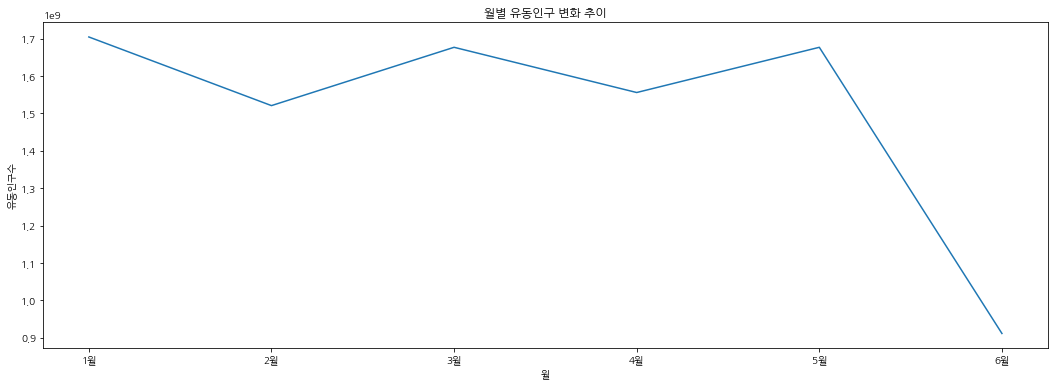

In [7]:
plt.figure(figsize=(18, 6))
plt.title('월별 유동인구 변화 추이')
plt.xlabel('월')
plt.ylabel('유동인구수')
plt.plot(fpop_month['월'], fpop_month['유동인구수'])
# plt.bar(fpop_month['월'], fpop_month['유동인구수'])
plt.show()

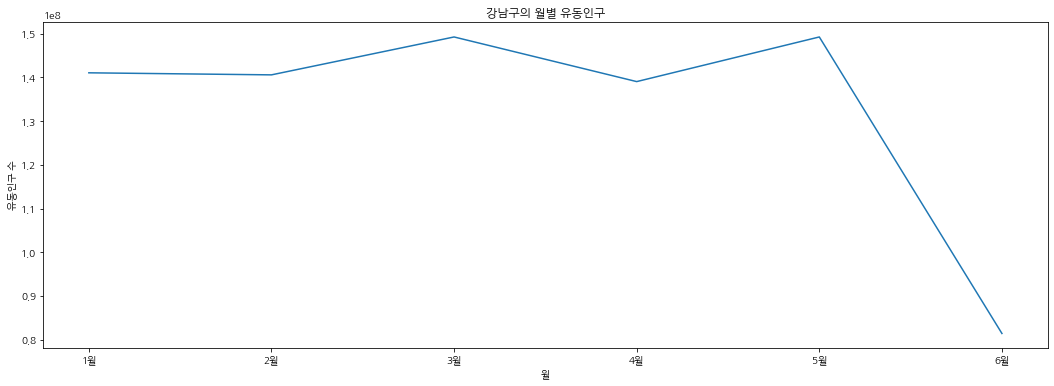

In [8]:
# 월별 데이터를 행정동으로 구분
Seoul_adstrd = Jan['signgu_nm'].unique()
Seoul_adstrd = Seoul_adstrd.tolist()

# 행정동별 유동인구를 뽑아내는 함수 생성
def adstrd_month(df, name):
  month_df = df[df['signgu_nm']==name]
  popsum = month_df['popltn_cascnt'].sum()
  return popsum

# 강남구 유동인구 월별 변화 
gangnam = pd.DataFrame(data={'월':['1월', '2월', '3월', '4월', '5월', '6월'], 
                             '유동인구 수': [adstrd_month(Jan, '강남구'), adstrd_month(Feb, '강남구'), adstrd_month(May, '강남구'), 
                             adstrd_month(Apr, '강남구'), adstrd_month(May, '강남구'), adstrd_month(Jun, '강남구')]})

# 시각화 
plt.figure(figsize=(18, 6))
plt.title("강남구의 월별 유동인구")
plt.xlabel('월')
plt.ylabel('유동인구 수')
plt.plot(gangnam['월'], gangnam['유동인구 수'])
plt.show()

## 8자리 행정동 코드
- adstrd_cord : 행정동 코드
- adstrd_nm : 행정동명
- brtc_nm : 시도명
- signgu_nm : 시군구명

In [ ]:
adstrd

,adstrd_code,adstrd_nm,brtc_nm,signgu_nm
0,11110515.0,청운효자동,서울특별시,종로구
1,11110530.0,사직동,서울특별시,종로구
2,11110540.0,삼청동,서울특별시,종로구
3,11110550.0,부암동,서울특별시,종로구
4,11110560.0,평창동,서울특별시,종로구
...,...,...,...,...
3488,50130580.0,서홍동,제주특별자치도,서귀포시
3489,50130590.0,대륜동,제주특별자치도,서귀포시
3490,50130600.0,대천동,제주특별자치도,서귀포시
3491,50130610.0,중문동,제주특별자치도,서귀포시


In [ ]:
adstrd[adstrd['brtc_nm']=='서울특별시'] # 8자리 행정동 코드

,adstrd_code,adstrd_nm,brtc_nm,signgu_nm
0,11110515,청운효자동,서울특별시,종로구
1,11110530,사직동,서울특별시,종로구
2,11110540,삼청동,서울특별시,종로구
3,11110550,부암동,서울특별시,종로구
4,11110560,평창동,서울특별시,종로구
...,...,...,...,...
420,11740650,성내2동,서울특별시,강동구
421,11740660,성내3동,서울특별시,강동구
422,11740685,길동,서울특별시,강동구
423,11740690,둔촌1동,서울특별시,강동구


행정동 코드를 통해 해당 지역의 명칭, 어느 시도군에 속하는지를 알려주는 데이터로 지역별 시각화에 도움을 주는 데이터이다. 

## 업종별 결제금액
- receipt_dttm : 카드회사가 카드 사용내역을 접수한 일자 
- adstrd_code : 행정동코드(가맹점 위치 기준) 
- adstrd_nm : 행정동명(가맹점 위치 기준)
- mrhst_induty_cl_code : 가맹점 업종코드
- mrhst_induty_cl_nm : 가맹점 업종명
- selng_cascnt : 매출발생건수
- salamt : 매출발생금액


In [ ]:
card # 업종별 결제금액

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
0,20200104,1174066000,성내3동,7041,약국,463,5843230
1,20200104,1174066000,성내3동,7022,치과의원,33,7835550
2,20200104,1174066000,성내3동,7021,한의원,53,4589800
3,20200104,1174066000,성내3동,7020,의원,339,9267240
4,20200104,1174066000,성내3동,6110,자동차정비,19,4441000
...,...,...,...,...,...,...,...
3777642,20200614,1121586000,구의2동,4004,대형할인점,136,1195640
3777643,20200614,1121584700,자양4동,9010,인테 리어,2,13100
3777644,20200614,1162052500,보라매동,6140,주 차 장,2,14500
3777645,20200614,1135056000,월계1동,9998,기타전문점,1,38000


In [ ]:
card['mrhst_induty_cl_nm'].value_counts() # 업종 분류 확인

일반한식         65528
서양음식         65499
편 의 점        65160
스넥           65007
미 용 원        64073
             ...  
카지노              8
통신기기무이자할부        8
택시회사             4
P2P송금            2
중고자동차위탁판매        1
Name: mrhst_induty_cl_nm, Length: 265, dtype: int64

In [ ]:
card['mrhst_induty_cl_nm'].unique()

array(['약국', '치과의원', '한의원', '의원', '자동차정비', '기타 교육', '보습학원', '일반 서적', '정장',
       '슈퍼 마켓', '편 의 점', '기타레져업', '노래방', '당구장', '헬스 크럽', '스포츠레져용품',
       '기계 공구', '기타건축자재', '기타음료식품', '농축수산품', '정 육 점', '제과점', '스넥', '주점',
       '서양음식', '중국음식', '일식회집', '일반한식', '화 장 품', '미 용 원', '주 차 장', '화   원',
       '비 영 리', '레져업소(회원제형태)', '예체능학원', '문구용 품', '사진관', '단란주점', '악세 사리',
       '기타숙박업', '세탁소', '유흥주점', '안경', '유아원', '기타잡화', '인터넷종합Mall', '대형할인점',
       '애완 동물', '학원(회원제형태)', '사무서비스', '독서실', '외국어학원', '피부미용실',
       '자사카드발행백화점', '영화관', '신   발', '내의판매점', '목재', '칵테일바', '기타대인서비스',
       '동물병원', '사무통신기기수리', '기타사무용품', '통신 기기', '출판인쇄물', '가전 제품', '기타유통업',
       '농축수산가공품', '종합용역', '병원', '기타가구', '자동차부품', '주 유 소', '안마/스포츠마사지',
       '스크린골프', '의료 용품', '조세서비스(특약)', '조세서비스', '기타서적문구', '인터넷Mall',
       '인터넷P/G', '기타전문점', '기타회원제형태업소4', '가정용품수리', '법률회계서비스(법인)', '소프트웨어',
       '부동산중개/임대', '화물 운송', '혼례서비스', '기타건강식', '주류판매점', '위탁급식업', '사우나',
       '미용 재료', '컴퓨터학원', '기타의류', '상품권', '골프연습장', '골프 용품', '관광여행', '유류 판매

업종별 카드 결제금액과 그에 따른 매출 정도를 알려주는 데이터이다. 가맹점 위치와 코드를 포함하고 있어 위의 두 가지 데이터와 연결시켜 분석할 수 있고, 지역/업종/매출 중 어느 기준을 우선으로 하느냐에 따라 다른 분석과 시각화를 보여줄 수 있다. 

## 배달 호출 정보
- SERIAL_NUMBER : 순번
- PROCESS_DT : 처리일시
- DLVR_RQESTER_ID : 배달요청업체 ID
- DLVR_REQUST_STTUS_VALUE : 배달요청상태값 (1:완료, 2:취소, 3:사고, 4:문의)
- DLVR_RCEPT_CMPNY_ID : 배달접수회사 ID
- DLVR_STORE_ID : 배달상점 ID
- DLVR_STORE_INDUTY_NM : 배달상점 업종이름
- DLVR_STORE_LEGALDONG_CODE : 배달상점 주소 법정동코드
- DLVR_STORE_SIDO : 배달상점 주소 법정동 시도명
- DLVR_STORE_SIGUNGU: 배달상점 주소 법정동 시군구명
- DLVR_STORE_DONG : 배달상점 주소 법정동 읍면동명
- DLVR_STORE_RI : 배달상점 주소 법정동 리명
- DLVR_STORE_ADSTRD_CODE : 배달상점 주소 행정동 코드
- DLVR_STORE_RDNMADR_CODE : 배달상점주소 도로명주소 코드
- DLVR_DSTN_LEGALDONG_CODE : 배달목적지 주소 법정동코드
- DLVR_DSTN_SIDO : 배달목적지 주소 법정동 시도명
- DLVR_DSTN_SIGUNGU : 배달목적지 주소 법정동 시군구명
- DLVR_DSTN_DONG : 배달목적지 주소 법정동 읍면동명
- DLVR_DSTN_RI : 배달목적지 주소 법정동 리명
- DLVR_DSTN_ADSTRD_CODE : 배달목적지 주소 행정동 코드
- DLVR_DSTN_RDNMADR_CODE : 배달목적지주소 도로명주소 코드
- DLVR_MAN_ID : 배달기사 ID
- DLVR_AMOUNT : 배달비용
- CALL_RLAY_FEE_AMOUNT : 호출중계수수료금액
- GOODS_AMOUNT : 배달상품금액
- SETLE_KND_VALUE : 결제종류번호 (1:카드, 2:선불, 3:현금)
- SETLE_CARD_CN : 결제카드종류
- DLVR_RCEPT_TIME : 배달접수시간
- DLVR_CARALC_TIME : 배달배차시간
- DLVR_COMPT_TIME : 배달완료시간
- DLVR_CANCL_TIME : 배달취소시간



In [ ]:
delivery # 배달 호출 정보

,SERIAL_NUMBER,PROCESS_DT,DLVR_RQESTER_ID,DLVR_REQUST_STTUS_VALUE,DLVR_RCEPT_CMPNY_ID,DLVR_STORE_ID,DLVR_STORE_INDUTY_NM,DLVR_STORE_LEGALDONG_CODE,DLVR_STORE_SIDO,DLVR_STORE_SIGUNGU,DLVR_STORE_DONG,DLVR_STORE_RI,DLVR_STORE_ADSTRD_CODE,DLVR_STORE_RDNMADR_CODE,DLVR_DSTN_LEGALDONG_CODE,DLVR_DSTN_SIDO,DLVR_DSTN_SIGUNGU,DLVR_DSTN_DONG,DLVR_DSTN_RI,DLVR_DSTN_ADSTRD_CODE,DLVR_DSTN_RDNMADR_CODE,DLVR_MAN_ID,DLVR_AMOUNT,CALL_RLAY_FEE_AMOUNT,GOODS_AMOUNT,SETLE_KND_VALUE,SETLE_CARD_CN,DLVR_RCEPT_TIME,DLVR_CARALC_TIME,DLVR_COMPT_TIME,DLVR_CANCL_TIME
0,4577985,2020-01-01,C000035,1,C000035,S0032342,치킨,4812710600,경상남도,창원시 마산회원구,합성동,NaN,4812759000,4.812748e+11,4.812710e+09,경상남도,창원시 마산회원구,석전동,NaN,4.812754e+09,4.812748e+11,D0005271,4290,300,25000,1,승인:비씨카드사,2020-01-01 00:15:49,2020-01-01 00:21:38,2020-01-01 00:41:37,NaN
1,4577986,2020-01-01,C000237,1,C000237,S0021847,찜탕,4121010200,경기도,광명시,철산동,NaN,4121061000,4.121030e+11,1.154510e+09,서울특별시,금천구,가산동,NaN,1.154551e+09,1.154531e+11,D0003269,4800,200,49000,2,NaN,2020-01-01 01:12:14,2020-01-01 01:21:41,2020-01-01 01:31:44,NaN
2,4577988,2020-01-01,C000129,1,C000129,S0025740,치킨,1138010400,서울특별시,은평구,갈현동,NaN,1138055100,1.138041e+11,1.138010e+09,서울특별시,은평구,갈현동,NaN,1.138055e+09,1.138041e+11,D0001536,3300,300,23000,3,승인:,2020-01-01 00:01:14,2020-01-01 00:01:47,2020-01-01 00:18:47,NaN
3,4577989,2020-01-01,C000029,1,C000043,S0039634,한식,4115010100,경기도,의정부시,의정부동,NaN,4115051000,4.115043e+11,4.115010e+09,경기도,의정부시,의정부동,NaN,4.115051e+09,4.115043e+11,D0005061,4500,300,20000,2,NaN,2020-01-01 01:01:34,2020-01-01 01:28:06,2020-01-01 01:36:48,NaN
4,4577991,2020-01-01,C000130,1,C000130,S0002237,한식,4128112800,경기도,고양시 덕양구,행신동,NaN,4128164000,4.128144e+11,4.128110e+09,경기도,고양시 덕양구,주교동,NaN,4.128151e+09,4.128144e+11,D0005215,6500,300,32000,2,NaN,2020-01-01 01:05:06,2020-01-01 01:08:01,2020-01-01 01:29:00,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5158319,10672688,2020-06-21,C000312,1,C000312,S0029529,야식,4125010200,경기도,동두천시,지행동,NaN,4125056500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D0013004,3000,500,26000,1,승인:하나카드,2020-06-21 22:48:22,2020-06-21 22:48:37,2020-06-21 23:07:47,NaN
5158320,10672689,2020-06-21,C000026,1,C000026,S0026242,야식,1132010800,서울특별시,도봉구,도봉동,NaN,1132052100,1.132041e+11,1.135010e+09,서울특별시,노원구,상계동,NaN,1.135063e+09,1.135041e+11,D0006251,3600,55,22000,2,NaN,2020-06-21 22:57:15,2020-06-21 22:58:00,2020-06-21 23:18:20,NaN
5158321,10672690,2020-06-21,C000130,1,C000130,S0042234,야식,4128112300,경기도,고양시 덕양구,화정동,NaN,4128162100,4.128132e+11,4.128112e+09,경기도,고양시 덕양구,화정동,NaN,4.128162e+09,4.128132e+11,D0012754,3000,300,17000,2,NaN,2020-06-21 22:55:08,2020-06-21 22:55:22,2020-06-21 23:14:45,NaN
5158322,10672691,2020-06-21,C000237,1,C000237,S0021766,족발/보쌈,4121010200,경기도,광명시,철산동,NaN,4121061000,4.121044e+11,4.121010e+09,경기도,광명시,철산동,NaN,4.121061e+09,4.121044e+11,D0004485,3630,200,53700,1,승인:비씨카드사,2020-06-21 23:10:38,2020-06-21 23:11:03,2020-06-21 23:25:10,NaN


제공된 데이터 중 가장 많은 정보를 담고 있다고 볼 수 있는 데이터로 코로나 사태 이후 배달업계의 상황을 파악할 수 있는 중요한 자료이다. 배달상점 주소와 배달 목적지 주소 사이의 거리를 비교하고 배달접수시간 사이의 차이를 측정해 배달업 활성 정도와 빈도수 증가 추이를 추측해볼 수 있다. 또한 배달접수업체/배달요청업체를 비교하여 순위를 매기거나, 행정동별 배달업체 순위나 신뢰도를 추측해볼 수도 있다. 

## 품목별 소비지수
- period : 기준월
- catl : 대분류
- catm : 중분류
- age : 나이대
- gender : 성별
- sido : 지역
- sigungu : 세부지역
- cgi : 카테고리성장지수 (2018년 월평균 대비 매출 성장 비율, 100을 기준으로 이상이면 매출 상승, 이하면 하락)

In [ ]:
index # 품목별 소비지수

,period,catl,catm,age,gender,sido,sigungu,cgi
0,201901,건강/의료용품,건강관리용품,20,F,서울,관악구,115.374642
1,201901,건강/의료용품,건강관리용품,20,F,서울,광진구,119.596454
2,201901,건강/의료용품,건강관리용품,20,F,서울,도봉구,156.992847
3,201901,건강/의료용품,건강관리용품,20,F,서울,동작구,58.342726
4,201901,건강/의료용품,건강관리용품,20,F,서울,마포구,145.147595
...,...,...,...,...,...,...,...,...
127520,202005,화장품,화장품,all,all,서울,강서구,51.365660
127521,202005,화장품,화장품,all,all,서울,관악구,61.997865
127522,202005,화장품,화장품,all,all,서울,금천구,82.198402
127523,202005,화장품,화장품,all,all,서울,도봉구,35.875600


In [ ]:
index['catl'].value_counts() # 대분류 분석

식품         79546
화장품        24383
일용품        15669
건강/의료용품     7927
Name: catl, dtype: int64

In [ ]:
index['catm'].value_counts() # 중분류 분석 

가공식품       7956
담배         7956
주류         7956
유제품류       7956
음료         7956
빵류         7956
생활용품       7956
제과류        7956
빙과류        7956
기호식품       7954
신선식품       7944
바디/헤어용품    7928
건강관리용품     7927
화장품        7899
뷰티소품       7788
애완동물용품     7713
기타화장품       768
Name: catm, dtype: int64

## 감정소비 업종 범위 선정
[기사](http://digitalchosun.dizzo.com/site/data/html_dir/2018/08/09/2018080912426.html)에 따르면, 성인남녀의 93% 이상은 감정소비로 스트레스를 풀고 있다고 한다. 코로나 19의 유행으로 인해 스트레스를 받는 사람이 많은 상황에서,감정소비의 패턴 변화를 살펴보는 것은 소비자 성향은 물론 사회의 변화를 읽는 데도 중요한 포인트가 될 수 있을 것이라 생각한다. 

2018년 기준 상위 감정소비 품목은 다음과 같다. 
<br><br>
![2018080912426_2](https://user-images.githubusercontent.com/58945760/88260906-40dada00-cd00-11ea-93a9-608f242020c2.jpg)

우선은 업종별 결제금액 데이터 중 감정소비에 해당하는 범위를 나누어 그 경향을 파악해본다. 이 중 저렴한 생활용품의 경우 해당 업종을 특정하기가 어렵고 다른 품목과 겹칠 위험이 있어 제외하였다. 



In [10]:
# 감정소비 업종 분류하기
beauty = card[card['mrhst_induty_cl_nm']=='화 장 품'] # 화장품
acce = card[(card['mrhst_induty_cl_nm']=='악세 사리') | (card['mrhst_induty_cl_nm']=='귀 금 속')] # 액세서리
bodycare = card[(card['mrhst_induty_cl_nm']=='미 용 원')|(card['mrhst_induty_cl_nm']=='피부미용실')|(card['mrhst_induty_cl_nm']=='미용 재료')|(card['mrhst_induty_cl_nm']=='안마/스포츠마사지')] # 미용건강
drink = card[(card['mrhst_induty_cl_nm']=='유흥주점')|(card['mrhst_induty_cl_nm']=='주류판매점')|(card['mrhst_induty_cl_nm']=='칵테일바')|(card['mrhst_induty_cl_nm']=='주점')|(card['mrhst_induty_cl_nm']=='단란주점')]
clothes = card[(card['mrhst_induty_cl_nm']=='양 품 점')|(card['mrhst_induty_cl_nm']=='단체복')|(card['mrhst_induty_cl_nm']=='맞춤복 점')|(card['mrhst_induty_cl_nm']=='와이셔츠/타이')|(card['mrhst_induty_cl_nm']=='캐주얼의류')|(card['mrhst_induty_cl_nm']=='제 화 점')|(card['mrhst_induty_cl_nm']=='기타의류')|(card['mrhst_induty_cl_nm']=='옷감 직물')|(card['mrhst_induty_cl_nm']=='기타직물')|(card['mrhst_induty_cl_nm']=='아동의류')|(card['mrhst_induty_cl_nm']=='정장')|(card['mrhst_induty_cl_nm']=='신   발')|(card['mrhst_induty_cl_nm']=='스포츠의류')|(card['mrhst_induty_cl_nm']=='가   방')]#의류
trip = card[(card['mrhst_induty_cl_nm']=='관광여행')|(card['mrhst_induty_cl_nm']=='기타레져업')|(card['mrhst_induty_cl_nm']=='레져업소(회원제형태)')|(card['mrhst_induty_cl_nm']=='기타숙박업')|(card['mrhst_induty_cl_nm']== '특급 호텔')|(card['mrhst_induty_cl_nm']=='1급 호텔')|(card['mrhst_induty_cl_nm']=='2급 호텔')|(card['mrhst_induty_cl_nm']=='종합레져타운')|(card['mrhst_induty_cl_nm']== '콘   도')|(card['mrhst_induty_cl_nm']== '스 키 장')|(card['mrhst_induty_cl_nm']=='렌 트 카')|(card['mrhst_induty_cl_nm']=='여 객 선')|(card['mrhst_induty_cl_nm']=='카지노')] # 여행
food = card[(card['mrhst_induty_cl_nm']=='서양음식')| (card['mrhst_induty_cl_nm']=='중국음식')|(card['mrhst_induty_cl_nm']=='일식회집')|(card['mrhst_induty_cl_nm']=='일반한식')|(card['mrhst_induty_cl_nm']=='제과점')|(card['mrhst_induty_cl_nm']=='한정식')] # 음식
entertain = card[(card['mrhst_induty_cl_nm']=='노래방')|(card['mrhst_induty_cl_nm']== '당구장')|(card['mrhst_induty_cl_nm']== '헬스 크럽')|(card['mrhst_induty_cl_nm']== '영화관')| (card['mrhst_induty_cl_nm']== '스크린골프')|(card['mrhst_induty_cl_nm']== '골프연습장')|(card['mrhst_induty_cl_nm']=='수 족 관')|(card['mrhst_induty_cl_nm']== '티켓')|(card['mrhst_induty_cl_nm']=='문화취미기타')| (card['mrhst_induty_cl_nm']=='테니스 장')|(card['mrhst_induty_cl_nm']== '볼 링 장')|(card['mrhst_induty_cl_nm']=='수 영 장') |(card['mrhst_induty_cl_nm']== '일반 서적')|(card['mrhst_induty_cl_nm']== '기타서적문구')] # 영화 및 문화생활
trip                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
11,20200104,1174066000,성내3동,2199,기타레져업,291,1340500
38,20200104,1174065000,성내2동,2199,기타레져업,277,1598900
42,20200104,1174064000,성내1동,9301,레져업소(회원제형태),6,899000
83,20200104,1174062000,천호3동,2199,기타레져업,165,805100
86,20200104,1174062000,천호3동,1020,기타숙박업,16,668000
...,...,...,...,...,...,...,...
3777544,20200614,1117051000,후암동,1020,기타숙박업,2,60000
3777565,20200614,1114068000,중림동,9301,레져업소(회원제형태),1,96000
3777582,20200614,1135071000,상계9동,2199,기타레져업,2,26000
3777583,20200614,1117055500,청파동,1130,렌 트 카,8,1419200


### 의류 
우선 월별 의류 소비의 변화를 알아보자.

In [ ]:
clothes

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
8,20200104,1174066000,성내3동,4201,정장,13,743000
80,20200104,1174062000,천호3동,4201,정장,40,2823850
113,20200104,1174061000,천호2동,4201,정장,38,1501300
138,20200104,1174060000,천호1동,4201,정장,22,908000
188,20200104,1174057000,암사1동,4201,정장,44,3503390
...,...,...,...,...,...,...,...
3777520,20200614,1153055000,구로4동,4420,제 화 점,2,50000
3777550,20200614,1165065200,양재2동,4210,맞춤복 점,1,121600
3777590,20200614,1117059000,용문동,4201,정장,2,32000
3777610,20200614,1174066000,성내3동,4210,맞춤복 점,2,72000


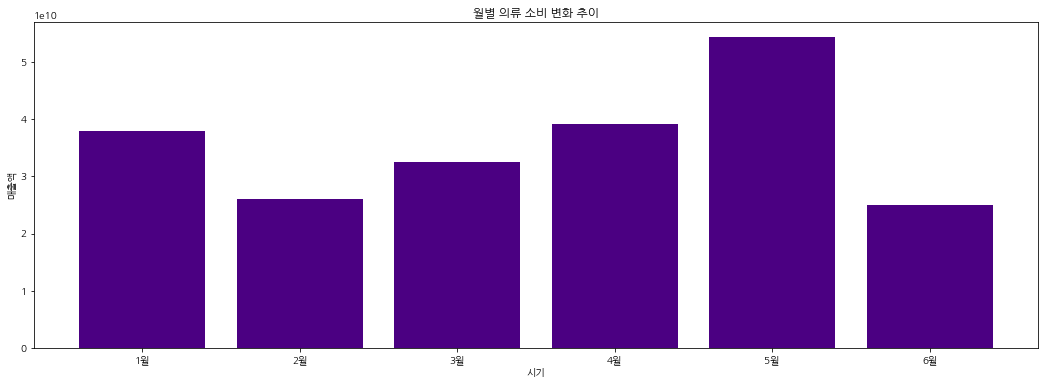

In [14]:
# 월별 소비 변화 
# 월별 슬라이싱
Jan = clothes[clothes['receipt_dttm'] <= 20200131] # 1월
Feb = clothes[(20200131 < clothes['receipt_dttm']) & (clothes['receipt_dttm'] < 20200300)] # 2월
Mar = clothes[(20200229 < clothes['receipt_dttm']) & (clothes['receipt_dttm'] < 20200400)] # 3월
Apr = clothes[(20200331 < clothes['receipt_dttm']) & (clothes['receipt_dttm'] < 20200500)] # 4월
May = clothes[(20200430 < clothes['receipt_dttm']) & (clothes['receipt_dttm'] < 20200600)] # 5월
Jun = clothes[20200600 < clothes['receipt_dttm']] # 6월

# 월별 매출액
Jan_sel = pd.to_numeric(Jan['salamt']).sum()
Feb_sel = pd.to_numeric(Feb['salamt']).sum()
Mar_sel = pd.to_numeric(Mar['salamt']).sum()
Apr_sel = pd.to_numeric(Apr['salamt']).sum()
May_sel = pd.to_numeric(May['salamt']).sum()
Jun_sel = pd.to_numeric(Jun['salamt']).sum()
# print('1월 총 매출액 :', Jan_sel)

# dataframe 만들기 
total_sel = pd.DataFrame(data={'월':['1월', '2월', '3월', '4월', '5월', '6월'], '매출발생건수':[Jan_sel,Feb_sel,Mar_sel,Apr_sel, May_sel, Jun_sel]}) # 단위 변화 함수 필요

# 시각화
plt.figure(figsize=(18, 6))
plt.title('월별 의류 소비 변화 추이')
plt.xlabel('시기')
plt.ylabel('매출액')
plt.bar(total_sel['월'], total_sel['매출발생건수'], color='indigo')
plt.show()

### 외식

In [ ]:
food

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
21,20200104,1174065000,성내2동,8301,제과점,264,2960930
24,20200104,1174065000,성내2동,8006,서양음식,403,3888210
25,20200104,1174065000,성내2동,8005,중국음식,90,1881190
26,20200104,1174065000,성내2동,8004,일식회집,70,1980800
27,20200104,1174065000,성내2동,8001,일반한식,932,28931200
...,...,...,...,...,...,...,...
3777329,20200614,1129059000,돈암2동,8301,제과점,13,98850
3777484,20200614,1123056000,전농1동,8003,한정식,4,190000
3777548,20200614,1117059000,용문동,8003,한정식,16,1448000
3777587,20200614,1150060400,가양2동,8004,일식회집,12,191100


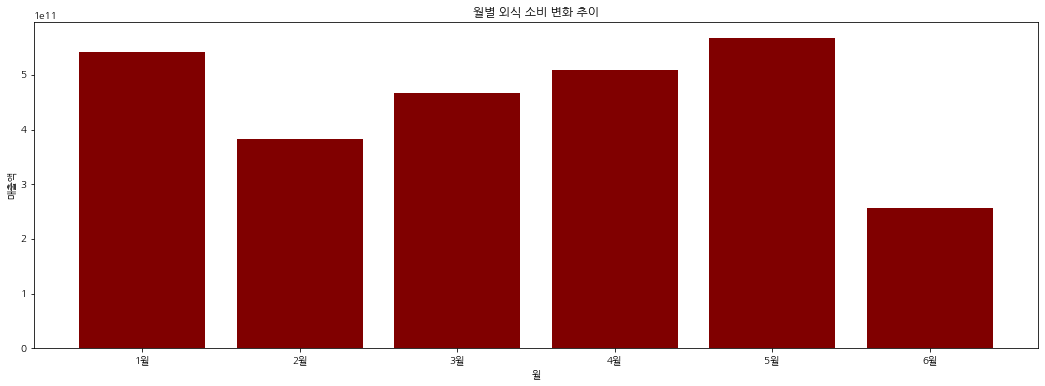

In [ ]:
# 월별 소비 변화 
# 월별 슬라이싱
Jan = food[food['receipt_dttm'] <= 20200131] # 1월
Feb = food[(20200131 < food['receipt_dttm']) & (food['receipt_dttm'] < 20200300)] # 2월
Mar = food[(20200229 < food['receipt_dttm']) & (food['receipt_dttm'] < 20200400)] # 3월
Apr = food[(20200331 < food['receipt_dttm']) & (food['receipt_dttm'] < 20200500)] # 4월
May = food[(20200430 < food['receipt_dttm']) & (food['receipt_dttm'] < 20200600)] # 5월
Jun = food[20200600 < food['receipt_dttm']] # 6월

# 월별 매출액
Jan_sel = pd.to_numeric(Jan['salamt']).sum()
Feb_sel = pd.to_numeric(Feb['salamt']).sum()
Mar_sel = pd.to_numeric(Mar['salamt']).sum()
Apr_sel = pd.to_numeric(Apr['salamt']).sum()
May_sel = pd.to_numeric(May['salamt']).sum()
Jun_sel = pd.to_numeric(Jun['salamt']).sum()
# print('1월 총 매출액 :', Jan_sel)

# dataframe 만들기 
total_sel = pd.DataFrame(data={'월':['1월', '2월', '3월', '4월', '5월','6월'], '매출발생건수':[Jan_sel, Feb_sel, Mar_sel, Apr_sel, May_sel, Jun_sel]}) # 단위 변화 함수 필요

def 1.3 
# 시각화
plt.figure(figsize=(18, 6))
plt.title('월별 외식 소비 변화 추이')
plt.xlabel('월')
plt.ylabel('매출액')
plt.bar(total_sel['월'], total_sel['매출발생건수'], color='maroon')
plt.show()

### 음주

In [ ]:
drink

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
23,20200104,1174065000,성내2동,8013,주점,73,2303600
46,20200104,1174064000,성내1동,8013,주점,30,907000
67,20200104,1174062000,천호3동,8201,단란주점,32,1696000
69,20200104,1174062000,천호3동,8013,주점,150,5835300
93,20200104,1174061000,천호2동,8201,단란주점,14,1697000
...,...,...,...,...,...,...,...
3777342,20200614,1121573000,군자동,8303,주류판매점,8,343900
3777353,20200614,1132051300,창3동,8010,칵테일바,3,69000
3777395,20200614,1144068000,합정동,8010,칵테일바,6,164000
3777507,20200614,1111056000,평창동,8010,칵테일바,8,209000


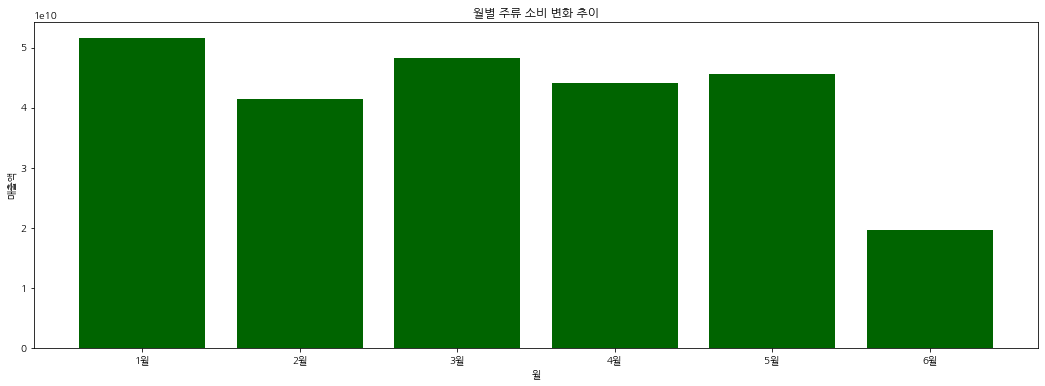

In [ ]:
# 월별 소비 변화 
# 월별 슬라이싱
Jan = drink[drink['receipt_dttm'] <= 20200131] # 1월
Feb = drink[(20200131 < drink['receipt_dttm']) & (drink['receipt_dttm'] < 20200300)] # 2월
Mar = drink[(20200229 < drink['receipt_dttm']) & (drink['receipt_dttm'] < 20200400)] # 3월
Apr = drink[(20200331 < drink['receipt_dttm']) & (drink['receipt_dttm'] < 20200500)] # 4월
May = drink[(20200430 < drink['receipt_dttm']) & (drink['receipt_dttm'] < 20200600)] # 5월
Jun = drink[20200600 < drink['receipt_dttm']] # 6월

# 월별 매출액
Jan_sel = pd.to_numeric(Jan['salamt']).sum()
Feb_sel = pd.to_numeric(Feb['salamt']).sum()
Mar_sel = pd.to_numeric(Mar['salamt']).sum()
Apr_sel = pd.to_numeric(Apr['salamt']).sum()
May_sel = pd.to_numeric(May['salamt']).sum()
Jun_sel = pd.to_numeric(Jun['salamt']).sum()
# print('1월 총 매출액 :', Jan_sel)

# dataframe 만들기 
total_sel = pd.DataFrame(data={'월':['1월', '2월', '3월', '4월', '5월','6월'], '매출발생건수':[Jan_sel, Feb_sel, Mar_sel, Apr_sel, May_sel, Jun_sel]}) # 단위 변화 함수 필요

# 시각화
plt.figure(figsize=(18, 6))
plt.title('월별 주류 소비 변화 추이')
plt.xlabel('월')
plt.ylabel('매출액')
plt.bar(total_sel['월'], total_sel['매출발생건수'], color='darkgreen')
plt.show()

### 문화생활

In [ ]:
entertain

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
7,20200104,1174066000,성내3동,5001,일반 서적,58,1292090
12,20200104,1174066000,성내3동,2130,노래방,21,1758000
13,20200104,1174066000,성내3동,2121,당구장,29,379100
14,20200104,1174066000,성내3동,2114,헬스 크럽,11,3566000
39,20200104,1174065000,성내2동,2130,노래방,18,632000
...,...,...,...,...,...,...,...
3777535,20200614,1141069000,남가좌1동,2130,노래방,2,355000
3777588,20200614,1147064000,신정3동,2104,스크린골프,8,375000
3777614,20200614,1168054500,압구정동,2250,영화관,1,73500
3777616,20200614,1135059500,공릉1동,5001,일반 서적,3,32500


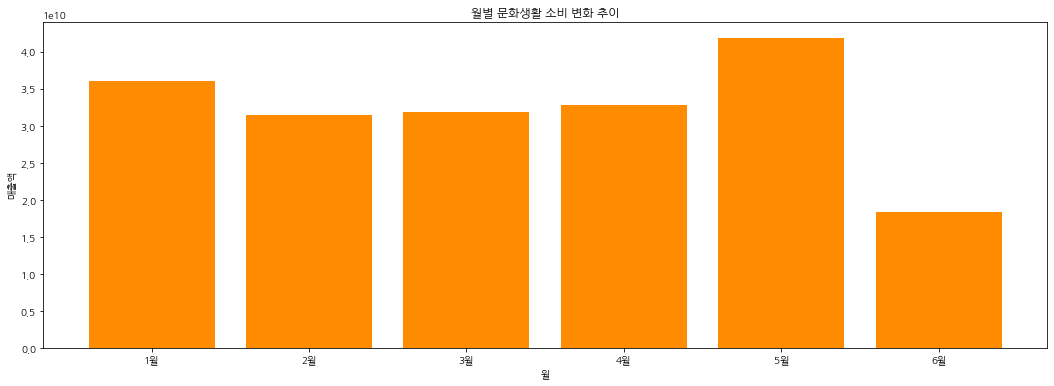

In [ ]:
# 월별 소비 변화 
# 월별 슬라이싱
Jan = entertain[entertain['receipt_dttm'] <= 20200131] # 1월
Feb = entertain[(20200131 < entertain['receipt_dttm']) & (entertain['receipt_dttm'] < 20200300)] # 2월
Mar = entertain[(20200229 < entertain['receipt_dttm']) & (entertain['receipt_dttm'] < 20200400)] # 3월
Apr = entertain[(20200331 < entertain['receipt_dttm']) & (entertain['receipt_dttm'] < 20200500)] # 4월
May = entertain[(20200430 < entertain['receipt_dttm']) & (entertain['receipt_dttm'] < 20200600)] # 5월
Jun = entertain[20200600 < entertain['receipt_dttm']] # 6월

# 월별 매출액
Jan_sel = pd.to_numeric(Jan['salamt']).sum()
Feb_sel = pd.to_numeric(Feb['salamt']).sum()
Mar_sel = pd.to_numeric(Mar['salamt']).sum()
Apr_sel = pd.to_numeric(Apr['salamt']).sum()
May_sel = pd.to_numeric(May['salamt']).sum()
Jun_sel = pd.to_numeric(Jun['salamt']).sum()
# print('1월 총 매출액 :', Jan_sel)

# dataframe 만들기 
total_sel = pd.DataFrame(data={'월':['1월', '2월', '3월', '4월', '5월','6월'], '매출발생건수':[Jan_sel, Feb_sel, Mar_sel, Apr_sel, May_sel, Jun_sel]}) # 단위 변화 함수 필요

# 시각화
plt.figure(figsize=(18, 6))
plt.title('월별 문화생활 소비 변화 추이')
plt.xlabel('월')
plt.ylabel('매출액')
plt.bar(total_sel['월'], total_sel['매출발생건수'], color='darkorange')
plt.show()

### 화장품

In [ ]:
beauty

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
28,20200104,1174065000,성내2동,7110,화 장 품,27,1176520
51,20200104,1174064000,성내1동,7110,화 장 품,31,2043600
101,20200104,1174061000,천호2동,7110,화 장 품,32,1620200
180,20200104,1174057000,암사1동,7110,화 장 품,56,2089180
243,20200104,1174053000,명일1동,7110,화 장 품,29,930100
...,...,...,...,...,...,...,...
3777188,20200614,1165065200,양재2동,7110,화 장 품,3,171000
3777299,20200614,1141064000,홍제3동,7110,화 장 품,1,18000
3777490,20200614,1129078000,장위3동,7110,화 장 품,2,100000
3777540,20200614,1111071000,숭인2동,7110,화 장 품,1,66000


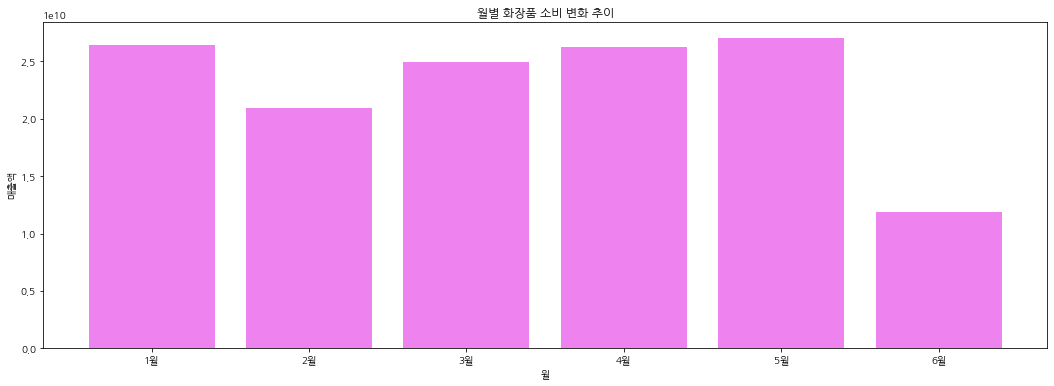

In [ ]:
# 월별 소비 변화 
# 월별 슬라이싱
Jan = beauty[beauty['receipt_dttm'] <= 20200131] # 1월
Feb = beauty[(20200131 < beauty['receipt_dttm']) & (beauty['receipt_dttm'] < 20200300)] # 2월
Mar = beauty[(20200229 < beauty['receipt_dttm']) & (beauty['receipt_dttm'] < 20200400)] # 3월
Apr = beauty[(20200331 < beauty['receipt_dttm']) & (beauty['receipt_dttm'] < 20200500)] # 4월
May = beauty[(20200430 < beauty['receipt_dttm']) & (beauty['receipt_dttm'] < 20200600)] # 5월
Jun = beauty[20200600 < beauty['receipt_dttm']] # 6월

# 월별 매출액
Jan_sel = pd.to_numeric(Jan['salamt']).sum()
Feb_sel = pd.to_numeric(Feb['salamt']).sum()
Mar_sel = pd.to_numeric(Mar['salamt']).sum()
Apr_sel = pd.to_numeric(Apr['salamt']).sum()
May_sel = pd.to_numeric(May['salamt']).sum()
Jun_sel = pd.to_numeric(Jun['salamt']).sum()
# print('1월 총 매출액 :', Jan_sel)

# dataframe 만들기 
total_sel = pd.DataFrame(data={'월':['1월', '2월', '3월', '4월', '5월','6월'], '매출발생건수':[Jan_sel, Feb_sel, Mar_sel, Apr_sel, May_sel, Jun_sel]}) # 단위 변화 함수 필요

# 시각화
plt.figure(figsize=(18, 6))
plt.title('월별 화장품 소비 변화 추이')
plt.xlabel('월')
plt.ylabel('매출액')
plt.bar(total_sel['월'], total_sel['매출발생건수'], color='violet')
plt.show()

### 여행상품

In [ ]:
trip

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
11,20200104,1174066000,성내3동,2199,기타레져업,291,1340500
38,20200104,1174065000,성내2동,2199,기타레져업,277,1598900
42,20200104,1174064000,성내1동,9301,레져업소(회원제형태),6,899000
83,20200104,1174062000,천호3동,2199,기타레져업,165,805100
86,20200104,1174062000,천호3동,1020,기타숙박업,16,668000
...,...,...,...,...,...,...,...
3777544,20200614,1117051000,후암동,1020,기타숙박업,2,60000
3777565,20200614,1114068000,중림동,9301,레져업소(회원제형태),1,96000
3777582,20200614,1135071000,상계9동,2199,기타레져업,2,26000
3777583,20200614,1117055500,청파동,1130,렌 트 카,8,1419200


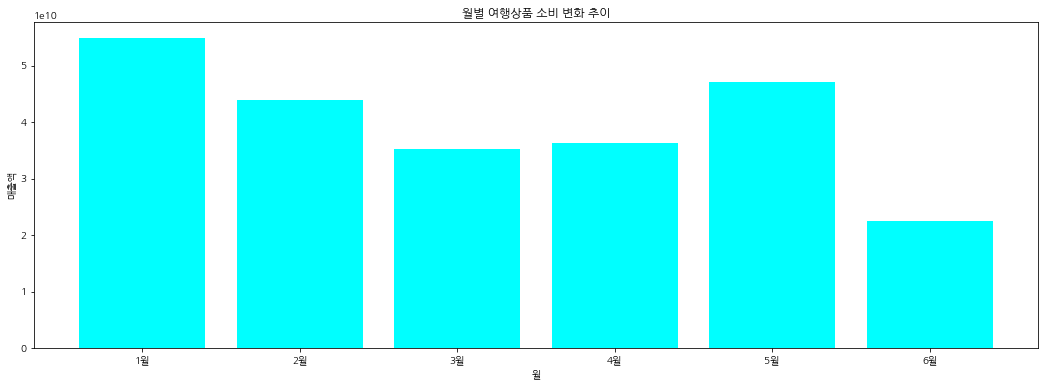

In [ ]:
# 월별 소비 변화 
# 월별 슬라이싱
Jan = trip[trip['receipt_dttm'] <= 20200131] # 1월
Feb = trip[(20200131 < trip['receipt_dttm']) & (trip['receipt_dttm'] < 20200300)] # 2월
Mar = trip[(20200229 < trip['receipt_dttm']) & (trip['receipt_dttm'] < 20200400)] # 3월
Apr = trip[(20200331 < trip['receipt_dttm']) & (trip['receipt_dttm'] < 20200500)] # 4월
May = trip[(20200430 < trip['receipt_dttm']) & (trip['receipt_dttm'] < 20200600)] # 5월
Jun = trip[20200600 < trip['receipt_dttm']] # 6월

# 월별 매출액
Jan_sel = pd.to_numeric(Jan['salamt']).sum()
Feb_sel = pd.to_numeric(Feb['salamt']).sum()
Mar_sel = pd.to_numeric(Mar['salamt']).sum()
Apr_sel = pd.to_numeric(Apr['salamt']).sum()
May_sel = pd.to_numeric(May['salamt']).sum()
Jun_sel = pd.to_numeric(Jun['salamt']).sum()
# print('1월 총 매출액 :', Jan_sel)

# dataframe 만들기 
total_sel = pd.DataFrame(data={'월':['1월', '2월', '3월', '4월', '5월','6월'], '매출발생건수':[Jan_sel, Feb_sel, Mar_sel, Apr_sel, May_sel, Jun_sel]}) # 단위 변화 함수 필요

# 시각화
plt.figure(figsize=(18, 6))
plt.title('월별 여행상품 소비 변화 추이')
plt.xlabel('월')
plt.ylabel('매출액')
plt.bar(total_sel['월'], total_sel['매출발생건수'], color='aqua')
plt.show()

### 미용건강

In [ ]:
bodycare

,receipt_dttm,adstrd_code,adstrd_nm,mrhst_induty_cl_code,mrhst_induty_cl_nm,selng_cascnt,salamt
29,20200104,1174065000,성내2동,7102,미 용 원,53,1617400
52,20200104,1174064000,성내1동,7102,미 용 원,30,1009000
74,20200104,1174062000,천호3동,7102,미 용 원,51,2058900
103,20200104,1174061000,천호2동,7102,미 용 원,98,3663450
133,20200104,1174060000,천호1동,7102,미 용 원,42,1310000
...,...,...,...,...,...,...,...
3777514,20200614,1129058000,돈암1동,7103,피부미용실,1,60000
3777542,20200614,1162062500,인헌동,7121,안마/스포츠마사지,3,635000
3777552,20200614,1147062000,신정1동,7103,피부미용실,2,135000
3777559,20200614,1147065000,신정4동,7111,미용 재료,1,10000


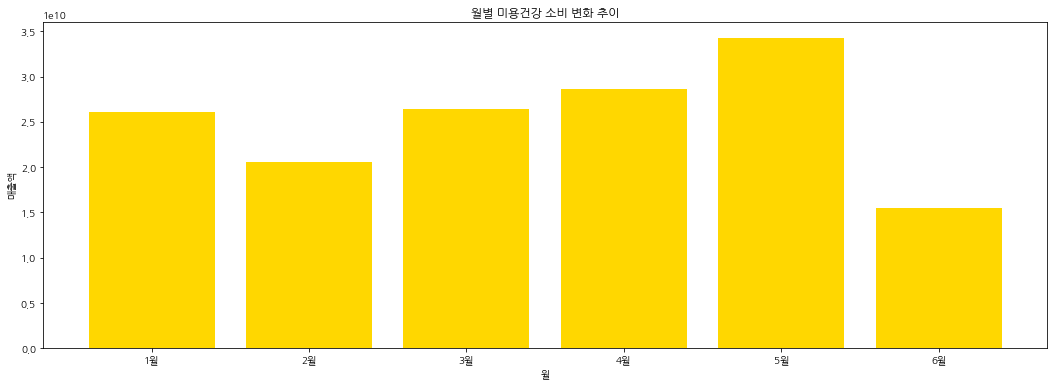

In [ ]:
# 월별 소비 변화 
# 월별 슬라이싱
Jan = bodycare[bodycare['receipt_dttm'] <= 20200131] # 1월
Feb = bodycare[(20200131 < bodycare['receipt_dttm']) & (bodycare['receipt_dttm'] < 20200300)] # 2월
Mar = bodycare[(20200229 < bodycare['receipt_dttm']) & (bodycare['receipt_dttm'] < 20200400)] # 3월
Apr = bodycare[(20200331 < bodycare['receipt_dttm']) & (bodycare['receipt_dttm'] < 20200500)] # 4월
May = bodycare[(20200430 < bodycare['receipt_dttm']) & (bodycare['receipt_dttm'] < 20200600)] # 5월
Jun = bodycare[20200600 < bodycare['receipt_dttm']] # 6월

# 월별 매출액
Jan_sel = pd.to_numeric(Jan['salamt']).sum()
Feb_sel = pd.to_numeric(Feb['salamt']).sum()
Mar_sel = pd.to_numeric(Mar['salamt']).sum()
Apr_sel = pd.to_numeric(Apr['salamt']).sum()
May_sel = pd.to_numeric(May['salamt']).sum()
Jun_sel = pd.to_numeric(Jun['salamt']).sum()
# print('1월 총 매출액 :', Jan_sel)

# dataframe 만들기 
total_sel = pd.DataFrame(data={'월':['1월', '2월', '3월', '4월', '5월','6월'], '매출발생건수':[Jan_sel, Feb_sel, Mar_sel, Apr_sel, May_sel, Jun_sel]}) # 단위 변화 함수 필요

# 시각화
plt.figure(figsize=(18, 6))
plt.title('월별 미용건강 소비 변화 추이')
plt.xlabel('월')
plt.ylabel('매출액')
plt.bar(total_sel['월'], total_sel['매출발생건수'], color='gold')
plt.show()

건수가 아닌 매출액으로 시각화를 시도한 이유는 업종 전반의 경향을 분석하는 데 더 용이하다고 판단했기 때문이다. 거래 건수가 많다고 해서 해당 업종이 번성한다고 보기는 어렵다. 산업 특성에 따라 매출액도 꼭 해당 업종의 변화 추이를 반영한다고 말할 수는 없지만 건수에 비해서는 보다 논리적인 근거로 볼 수 있다.    

In [ ]:
# 현재 설정되어 있는 폰트 사이즈와 글꼴을 알아보기
# !python --version
# def current_font():
#   print(f"설정 폰트 글꼴: {plt.rcParams['font.family']}, 설정 폰트 사이즈: {plt.rcParams['font.size']}")  # 파이썬 3.6 이상 사용가능하다
        
# current_font()

Python 3.6.9
설정 폰트 글꼴: ['NanumGothic'], 설정 폰트 사이즈: 10.0


## 업종별 매출 순위 비교 TOP 5
이제 각 업종 안에서 매출 순위가 높은 세부 분류를 따져보자. 우선, 각 업종 전체의 규모를 비교해보자. 

### 업종 전체 규모 비교

In [106]:
# 각 업종별 세부 분류 
clothes_value = clothes['mrhst_induty_cl_nm'].unique()
drink_value = drink['mrhst_induty_cl_nm'].unique()
food_value = food['mrhst_induty_cl_nm'].unique()
entertain_value = entertain['mrhst_induty_cl_nm'].unique()
trip_value = trip['mrhst_induty_cl_nm'].unique()
beauty_value = beauty['mrhst_induty_cl_nm'].unique()
bodycare_value = bodycare['mrhst_induty_cl_nm'].unique()


# 세부 분류별 매출액 합산해주는 함수
def sum_salamt(dataframe, name_column, value_column, num): # num은 월 숫자
  # print('함수 실행')

  values = dataframe[name_column].unique().tolist()
  # print(values)

  Jan = dataframe[dataframe['receipt_dttm'] <= 20200131] # 1월
  Feb = dataframe[(20200131 < dataframe['receipt_dttm']) & (dataframe['receipt_dttm'] < 20200300)] # 2월
  Mar = dataframe[(20200229 < dataframe['receipt_dttm']) & (dataframe['receipt_dttm'] < 20200400)] # 3월
  Apr = dataframe[(20200331 < dataframe['receipt_dttm']) & (dataframe['receipt_dttm'] < 20200500)] # 4월
  May = dataframe[(20200430 < dataframe['receipt_dttm']) & (dataframe['receipt_dttm'] < 20200600)] # 5월
  Jun = dataframe[20200600 < dataframe['receipt_dttm']] # 6월


  sum_salamt_li = []
  if num ==1:
    Jan = Jan.astype({value_column : int})
    for n in values:
      sum_num = Jan[Jan[name_column] == n][value_column].sum()
      # print('{}업종의 {}월 매출액 합계는 {}입니다.'.format(n, num, sum_num))
      sum_salamt_li.append(sum_num)
    
  elif num == 2:
    Feb = Feb.astype({value_column : int})
    for n in values:
      sum_num = Feb[Feb[name_column]== n][value_column].sum()
      # print('{}업종의 {}월 매출액 합계는 {}입니다.'.format(n, num, sum_num))
      sum_salamt_li.append(sum_num)
  
  elif num == 3:
    Mar = Mar.astype({value_column : int})
    for n in values:
      sum_num = Mar[Mar[name_column]== n][value_column].sum()
      # print('{}업종의 {}월 매출액 합계는 {}입니다.'.format(n, num, sum_num))
      sum_salamt_li.append(sum_num)
  
  elif num == 4:
    Apr = Apr.astype({value_column : int})
    for n in values:
      sum_num = Apr[Apr[name_column]== n][value_column].sum()
      # print('{}업종의 {}월 매출액 합계는 {}입니다.'.format(n, num, sum_num))
      sum_salamt_li.append(sum_num)
  
  elif num == 5:
    May = May.astype({value_column : int})
    for n in values:
      sum_num = May[May[name_column]== n][value_column].sum()
      # print('{}업종의 {}월 매출액 합계는 {}입니다.'.format(n, num, sum_num))
      sum_salamt_li.append(sum_num)
  
  else:
    Jun = Jun.astype({value_column : int})
    for n in values:
      sum_num = Jun[Jun[name_column]== n][value_column].sum()
      # print('{}업종의 {}월 매출액 합계는 {}입니다.'.format(n, num, sum_num))
      sum_salamt_li.append(sum_num)

  return sum_salamt_li

# 매출 총합을 구해주는 함수 
def total_sum(dataframe, name_column, value_column, max_num):
  total_li = []
  for i in range(1, max_num):
    li_sum = sum(sum_salamt(dataframe, name_column, value_column, i))
    total_li.append(li_sum)

  return sum(total_li)


# 업종별 TOP 5만 dataframe으로 만드는 함수
def make_top5(column1, column2, month):
  df = pd.DataFrame(data = {'세부 분류' : column2, '매출액' : sum_salamt(column1,'mrhst_induty_cl_nm','salamt', month)})
  df = df.sort_values(by='매출액', ascending=False)
  return df[:5]

### 업종 전체 규모 비교

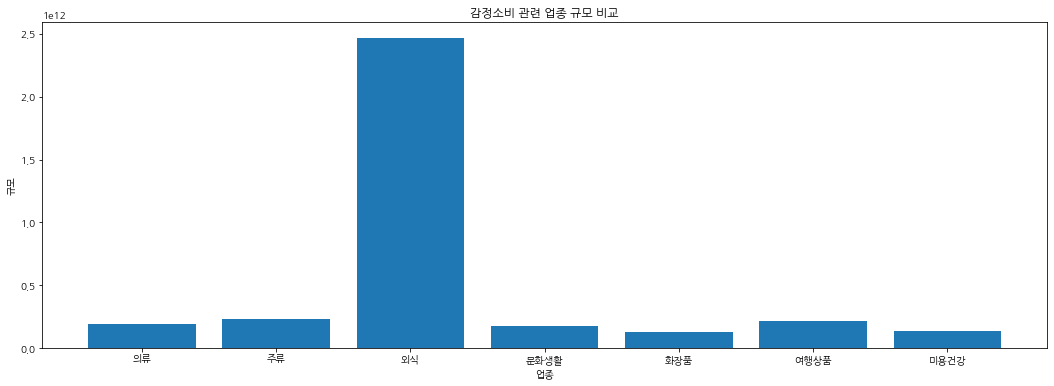

In [109]:
# 의류
c_total = total_sum(clothes,'mrhst_induty_cl_nm','salamt', 6)

# 주류
d_total = total_sum(drink,'mrhst_induty_cl_nm','salamt', 6)

# 외식
f_total =  total_sum(food,'mrhst_induty_cl_nm','salamt', 6)

# 문화생활
e_total = total_sum(entertain,'mrhst_induty_cl_nm','salamt', 6)

# 화장품
b_total = total_sum(beauty,'mrhst_induty_cl_nm','salamt', 6)

# 여행상품
t_total = total_sum(trip,'mrhst_induty_cl_nm','salamt', 6)

# 미용건강
bc_total = total_sum(bodycare,'mrhst_induty_cl_nm','salamt', 6)


# 시각화
df_total = pd.DataFrame(data={'업종' : ['의류', '주류', '외식', '문화생활', '화장품', '여행상품', '미용건강'], '규모' : [c_total, d_total, f_total, e_total, b_total, t_total, bc_total]})

plt.figure(figsize=(18, 6))
plt.title("감정소비 관련 업종 규모 비교")
plt.xlabel('업종')
plt.ylabel('규모')
plt.bar(df_total['업종'], df_total['규모'])
plt.show()

보다시피, 매출 규모로 봤을 때는 외식이 압도적이며 그 뒤를 여행상품과 주류 > 문화생활과 의류 > 화장품, 미용건강 순으로 나열됨을 알 수 있다. 이제는 각 업종 안의 세부 분류 top 5를 알아보자. 

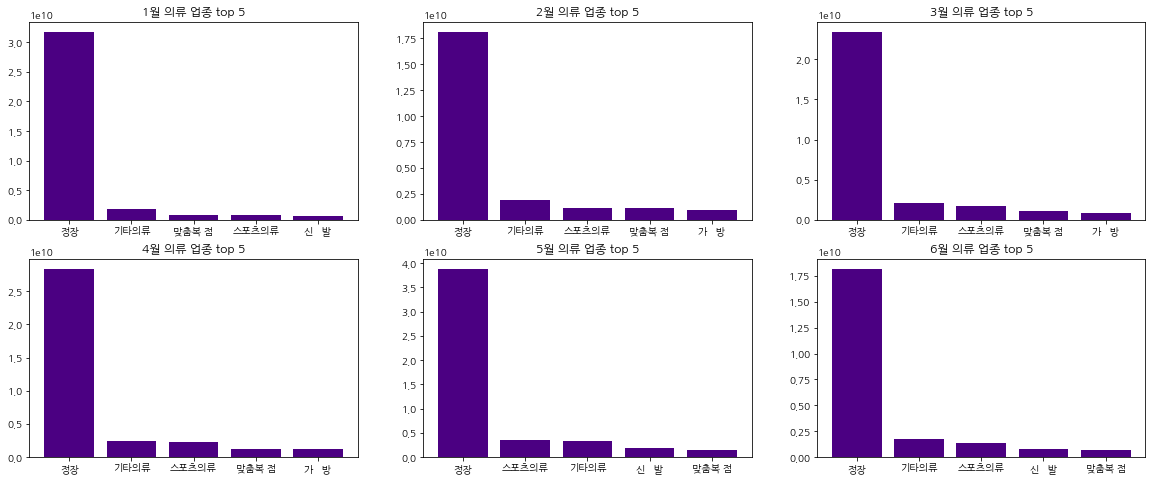

In [89]:
# 각 업종별 TOP 5
# 의류
df1 = make_top5(clothes, clothes_value, 1)
df2 = make_top5(clothes, clothes_value, 2)
df3 = make_top5(clothes, clothes_value, 3)
df4 = make_top5(clothes, clothes_value, 4)
df5 = make_top5(clothes, clothes_value, 5)
df6 = make_top5(clothes, clothes_value, 6)

# 시각화
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

ax[0, 0].set_title('1월 의류 업종 top 5')
ax[0, 0].bar(df1['세부 분류'], df1['매출액'], color='indigo')
ax[0, 1].set_title('2월 의류 업종 top 5')
ax[0, 1].bar(df2['세부 분류'], df2['매출액'], color='indigo')
ax[0, 2].set_title('3월 의류 업종 top 5')
ax[0, 2].bar(df3['세부 분류'], df3['매출액'], color='indigo')
ax[1, 0].set_title('4월 의류 업종 top 5')
ax[1, 0].bar(df4['세부 분류'], df4['매출액'], color='indigo')
ax[1, 1].set_title('5월 의류 업종 top 5')
ax[1, 1].bar(df5['세부 분류'], df5['매출액'], color='indigo')
ax[1, 2].set_title('6월 의류 업종 top 5')
ax[1, 2].bar(df6['세부 분류'], df6['매출액'], color='indigo')

plt.show()

6월까지 전체 액수 규모는 변했지만,  top 5 순위가 거의 변하지 않는 것을 볼 수 있다. 5월 한 달만 스포츠 의류가 매출 2위인 것은 코로나의 지속으로 홈트를 시작하게 된 인구가 늘어났기 때문으로 보인다. 실제로 4위였던 스포츠 의류 매출 규모는 2월부터 죽 3위~2위를 지키고 있다. 

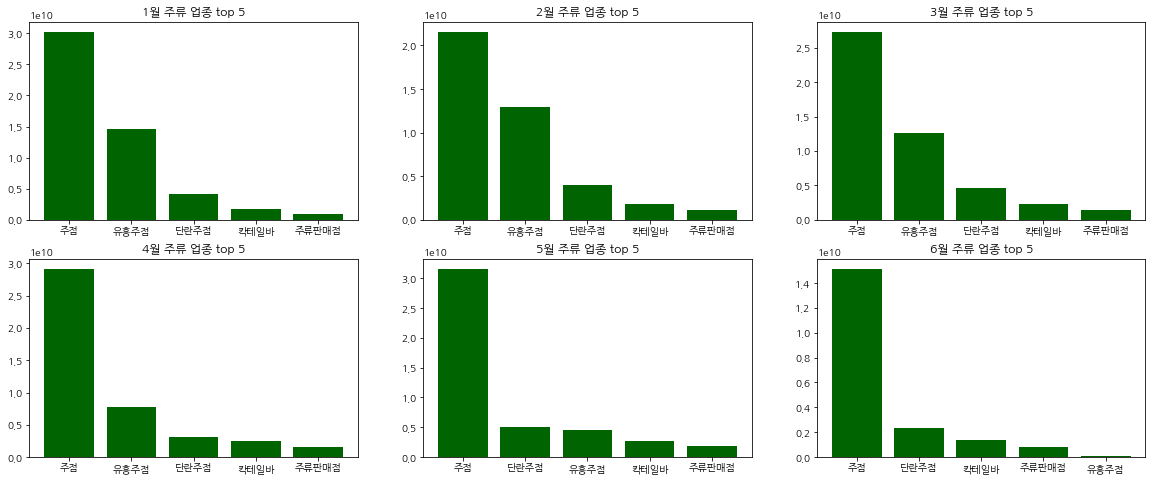

In [90]:
# 각 업종별 TOP 5
# 주류
df1 = make_top5(drink, drink_value, 1)
df2 = make_top5(drink, drink_value, 2)
df3 = make_top5(drink, drink_value, 3)
df4 = make_top5(drink, drink_value, 4)
df5 = make_top5(drink, drink_value, 5)
df6 = make_top5(drink, drink_value, 6)

# 시각화
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

ax[0, 0].set_title('1월 주류 업종 top 5')
ax[0, 0].bar(df1['세부 분류'], df1['매출액'], color='darkgreen')
ax[0, 1].set_title('2월 주류 업종 top 5')
ax[0, 1].bar(df2['세부 분류'], df2['매출액'], color='darkgreen')
ax[0, 2].set_title('3월 주류 업종 top 5')
ax[0, 2].bar(df3['세부 분류'], df3['매출액'], color='darkgreen')
ax[1, 0].set_title('4월 주류 업종 top 5')
ax[1, 0].bar(df4['세부 분류'], df4['매출액'], color='darkgreen')
ax[1, 1].set_title('5월 주류 업종 top 5')
ax[1, 1].bar(df5['세부 분류'], df5['매출액'], color='darkgreen')
ax[1, 2].set_title('6월 주류 업종 top 5')
ax[1, 2].bar(df6['세부 분류'], df6['매출액'], color='darkgreen')

plt.show()

주류의 경우 계속 2위를 고수하던 유흥주점이 영업금지의 타격으로 인해 5월부터 매출이 대폭 줄었고, 6월 초순에도 그런 경향이 나타남을 알 수 있다.  

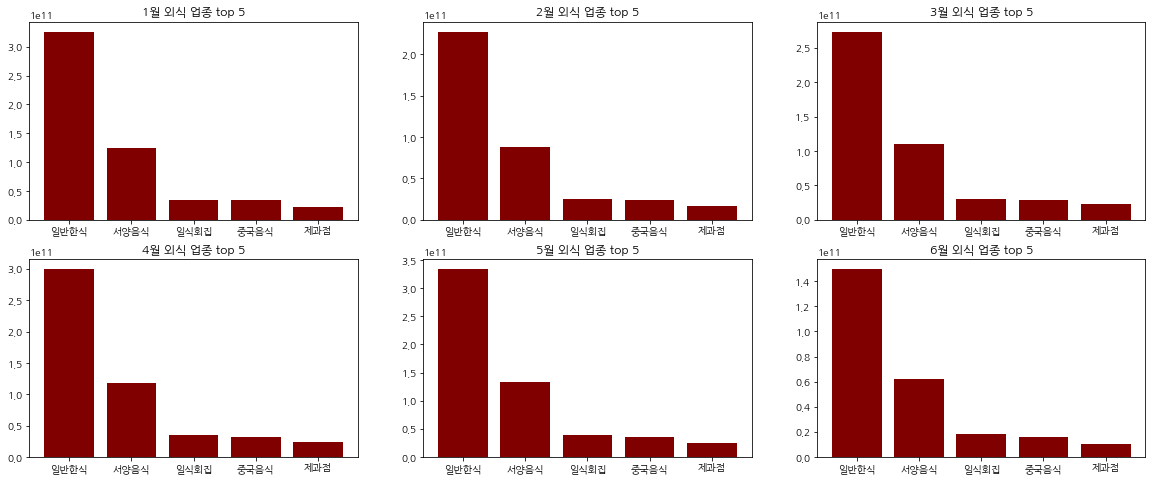

In [91]:
# 각 업종별 TOP 5
# 외식
df1 = make_top5(food, food_value, 1)
df2 = make_top5(food, food_value, 2)
df3 = make_top5(food, food_value, 3)
df4 = make_top5(food, food_value, 4)
df5 = make_top5(food, food_value, 5)
df6 = make_top5(food, food_value, 6)

# 시각화
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

ax[0, 0].set_title('1월 외식 업종 top 5')
ax[0, 0].bar(df1['세부 분류'], df1['매출액'], color='maroon')
ax[0, 1].set_title('2월 외식 업종 top 5')
ax[0, 1].bar(df2['세부 분류'], df2['매출액'], color='maroon')
ax[0, 2].set_title('3월 외식 업종 top 5')
ax[0, 2].bar(df3['세부 분류'], df3['매출액'], color='maroon')
ax[1, 0].set_title('4월 외식 업종 top 5')
ax[1, 0].bar(df4['세부 분류'], df4['매출액'], color='maroon')
ax[1, 1].set_title('5월 외식 업종 top 5')
ax[1, 1].bar(df5['세부 분류'], df5['매출액'], color='maroon')
ax[1, 2].set_title('6월 외식 업종 top 5')
ax[1, 2].bar(df6['세부 분류'], df6['매출액'], color='maroon')

plt.show()

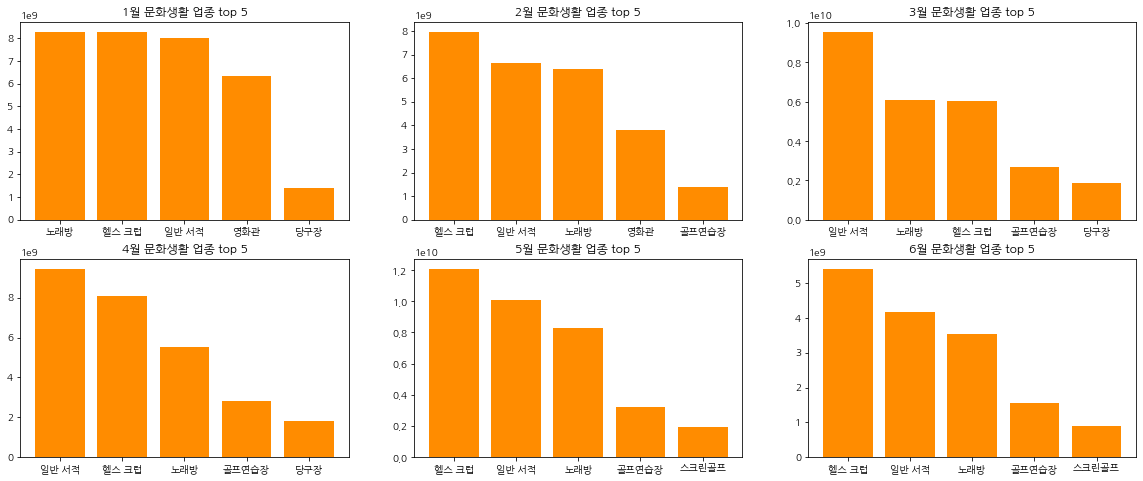

In [93]:
# 각 업종별 TOP 5
# 문화생활
df1 = make_top5(entertain, entertain_value, 1)
df2 = make_top5(entertain, entertain_value, 2)
df3 = make_top5(entertain, entertain_value, 3)
df4 = make_top5(entertain, entertain_value, 4)
df5 = make_top5(entertain, entertain_value, 5)
df6 = make_top5(entertain, entertain_value, 6)

# 시각화
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

ax[0, 0].set_title('1월 문화생활 업종 top 5')
ax[0, 0].bar(df1['세부 분류'], df1['매출액'], color='darkorange')
ax[0, 1].set_title('2월 문화생활 업종 top 5')
ax[0, 1].bar(df2['세부 분류'], df2['매출액'], color='darkorange')
ax[0, 2].set_title('3월 문화생활 업종 top 5')
ax[0, 2].bar(df3['세부 분류'], df3['매출액'], color='darkorange')
ax[1, 0].set_title('4월 문화생활 업종 top 5')
ax[1, 0].bar(df4['세부 분류'], df4['매출액'], color='darkorange')
ax[1, 1].set_title('5월 문화생활 업종 top 5')
ax[1, 1].bar(df5['세부 분류'], df5['매출액'], color='darkorange')
ax[1, 2].set_title('6월 문화생활 업종 top 5')
ax[1, 2].bar(df6['세부 분류'], df6['매출액'], color='darkorange')

plt.show()

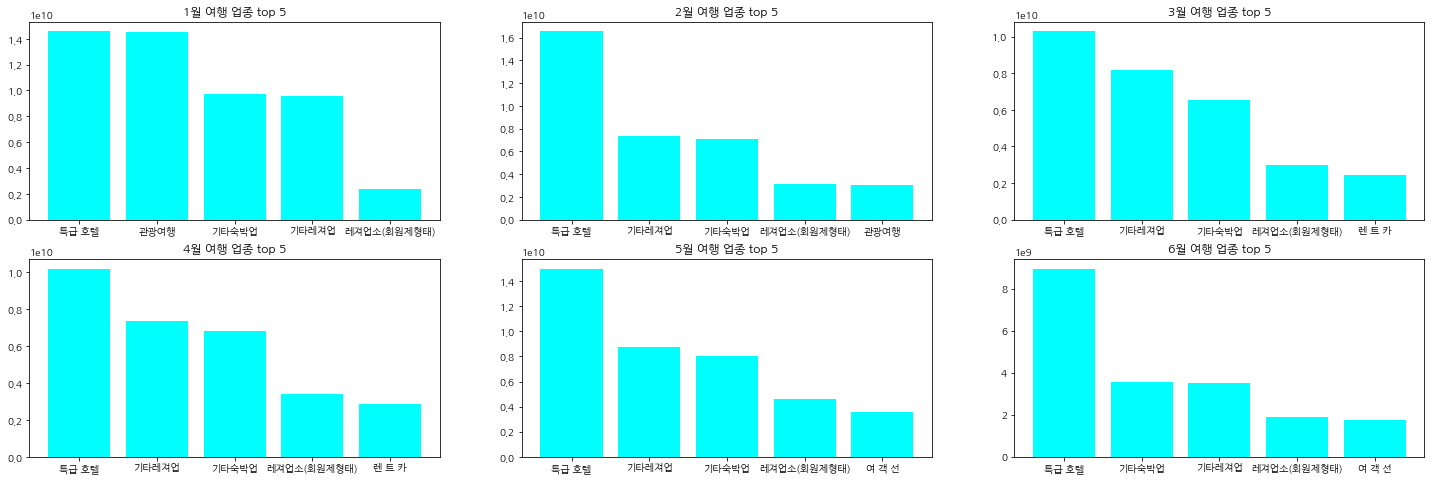

In [95]:
# 각 업종별 TOP 5
# 여행
df1 = make_top5(trip, trip_value, 1)
df2 = make_top5(trip, trip_value, 2)
df3 = make_top5(trip, trip_value, 3)
df4 = make_top5(trip, trip_value, 4)
df5 = make_top5(trip, trip_value, 5)
df6 = make_top5(trip, trip_value, 6)

# 시각화
fig, ax = plt.subplots(2, 3, figsize=(25, 8))

ax[0, 0].set_title('1월 여행 업종 top 5')
ax[0, 0].bar(df1['세부 분류'], df1['매출액'], color='aqua')
ax[0, 1].set_title('2월 여행 업종 top 5')
ax[0, 1].bar(df2['세부 분류'], df2['매출액'], color='aqua')
ax[0, 2].set_title('3월 여행 업종 top 5')
ax[0, 2].bar(df3['세부 분류'], df3['매출액'], color='aqua')
ax[1, 0].set_title('4월 여행 업종 top 5')
ax[1, 0].bar(df4['세부 분류'], df4['매출액'], color='aqua')
ax[1, 1].set_title('5월 여행 업종 top 5')
ax[1, 1].bar(df5['세부 분류'], df5['매출액'], color='aqua')
ax[1, 2].set_title('6월 여행 업종 top 5')
ax[1, 2].bar(df6['세부 분류'], df6['매출액'], color='aqua')

plt.show()

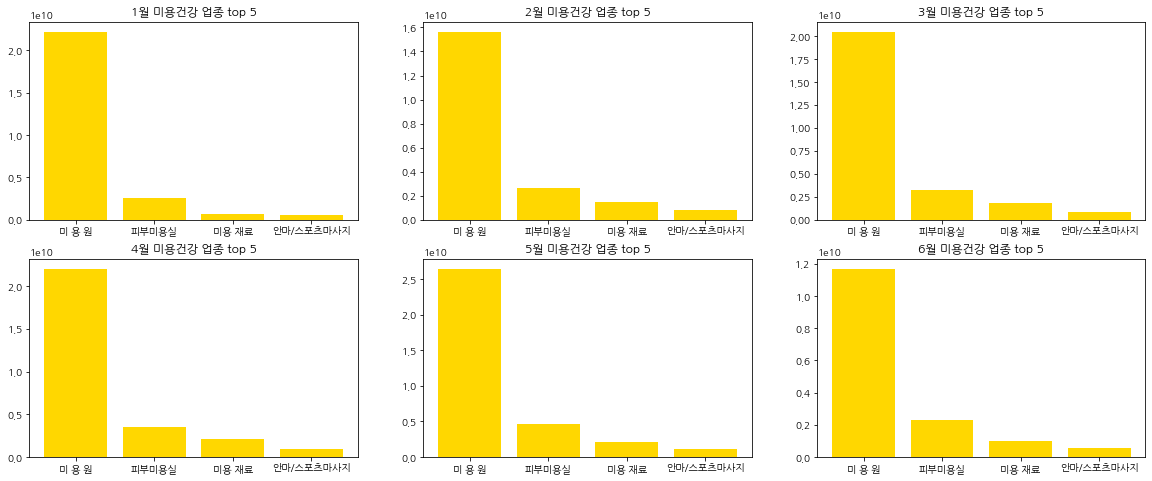

In [99]:
# 각 업종별 TOP 5
# 미용건강
df1 = make_top5(bodycare, bodycare_value, 1)
df2 = make_top5(bodycare, bodycare_value, 2)
df3 = make_top5(bodycare, bodycare_value, 3)
df4 = make_top5(bodycare, bodycare_value, 4)
df5 = make_top5(bodycare, bodycare_value, 5)
df6 = make_top5(bodycare, bodycare_value, 6)

# 시각화
fig, ax = plt.subplots(2, 3, figsize=(20, 8))

ax[0, 0].set_title('1월 미용건강 업종 top 5')
ax[0, 0].bar(df1['세부 분류'], df1['매출액'], color='gold')
ax[0, 1].set_title('2월 미용건강 업종 top 5')
ax[0, 1].bar(df2['세부 분류'], df2['매출액'], color='gold')
ax[0, 2].set_title('3월 미용건강 업종 top 5')
ax[0, 2].bar(df3['세부 분류'], df3['매출액'], color='gold')
ax[1, 0].set_title('4월 미용건강 업종 top 5')
ax[1, 0].bar(df4['세부 분류'], df4['매출액'], color='gold')
ax[1, 1].set_title('5월 미용건강 업종 top 5')
ax[1, 1].bar(df5['세부 분류'], df5['매출액'], color='gold')
ax[1, 2].set_title('6월 미용건강 업종 top 5')
ax[1, 2].bar(df6['세부 분류'], df6['매출액'], color='gold')

plt.show()